In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

In [41]:
# Define transforms (convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load training dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',           # Directory to save/load data
    train=True,              # Load training set
    download=True,           # Download if not already present
    transform=transform      # Apply transforms
)

# Load test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,             # Load test set
    download=True,
    transform=transform
)

In [42]:
# Define the neural network
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # Input: 28x28 = 784 pixels
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)  # 10 classes (digits 0-9)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten the image: (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(-1, 784)
        
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        x = F.relu(self.fc3(x))   # No activation here, will use CrossEntropyLoss
        x = self.fc4(x)
        return x

In [43]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MNISTNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

def train(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    model.train()
    train_batch_losses = []
    train_epoch_losses = []
    test_epoch_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_batch_losses.append(loss.item())
            if batch_idx % 200 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
        epoch_loss = running_loss / len(train_loader)
        train_epoch_losses.append(epoch_loss)

        # Evaluate test loss at the end of each epoch
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
        test_epoch_losses.append(test_loss / len(test_loader))
        model.train()

        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Test Loss: {test_epoch_losses[-1]:.4f}')
    return train_batch_losses, train_epoch_losses, test_epoch_losses


In [45]:
# Testing function
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [46]:
# Train and test the model
print(f"Using device: {device}")
train_batch_losses, train_epoch_losses, test_epoch_losses = train(
    model, train_loader, test_loader, criterion, optimizer, epochs=10
)
test(model, test_loader)

Using device: cpu
Epoch 1/10, Batch 0, Loss: 2.2836
Epoch 1/10, Batch 200, Loss: 0.3475
Epoch 1/10, Batch 400, Loss: 0.3219
Epoch 1/10, Batch 600, Loss: 0.1965
Epoch 1/10, Batch 800, Loss: 0.2783
Epoch 1/10, Batch 1000, Loss: 0.1277
Epoch 1/10, Batch 1200, Loss: 0.2875
Epoch 1/10, Batch 1400, Loss: 0.4511
Epoch 1/10, Batch 1600, Loss: 0.0613
Epoch 1/10, Batch 1800, Loss: 0.1351
Epoch 1/10 - Train Loss: 0.3714, Test Loss: 0.1805
Epoch 2/10, Batch 0, Loss: 0.0680
Epoch 2/10, Batch 200, Loss: 0.1459
Epoch 2/10, Batch 400, Loss: 0.1507
Epoch 2/10, Batch 600, Loss: 0.0705
Epoch 2/10, Batch 800, Loss: 0.2486
Epoch 2/10, Batch 1000, Loss: 0.1077
Epoch 2/10, Batch 1200, Loss: 0.0790
Epoch 2/10, Batch 1400, Loss: 0.2154
Epoch 2/10, Batch 1600, Loss: 0.0250
Epoch 2/10, Batch 1800, Loss: 0.0798
Epoch 2/10 - Train Loss: 0.1653, Test Loss: 0.1357
Epoch 3/10, Batch 0, Loss: 0.0565
Epoch 3/10, Batch 200, Loss: 0.0791
Epoch 3/10, Batch 400, Loss: 0.3006
Epoch 3/10, Batch 600, Loss: 0.0816
Epoch 3/10, 

NameError: name 'train_epoch_accuracies' is not defined

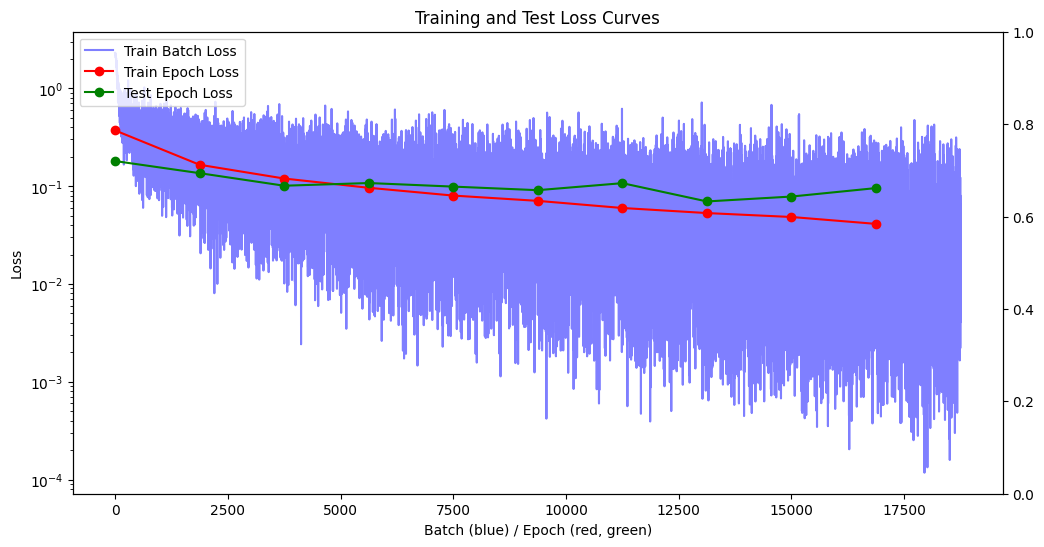

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_batch_losses, label='Train Batch Loss', color='blue', alpha=0.5)
plt.plot(
    [i * len(train_batch_losses) // len(train_epoch_losses) for i in range(len(train_epoch_losses))],
    train_epoch_losses, label='Train Epoch Loss', color='red', marker='o'
)
plt.plot(
    [i * len(train_batch_losses) // len(test_epoch_losses) for i in range(len(test_epoch_losses))],
    test_epoch_losses, label='Test Epoch Loss', color='green', marker='o'
)
plt.xlabel('Batch (blue) / Epoch (red, green)')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Test Loss Curves')
plt.legend(loc='upper left')

# Accuracy on right y-axis
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(
    [i * len(train_batch_losses) // len(train_epoch_accuracies) for i in range(len(train_epoch_accuracies))],
    train_epoch_accuracies, label='Train Accuracy', color='orange', marker='s', linestyle='--'
)
ax2.plot(
    [i * len(train_batch_losses) // len(test_epoch_accuracies) for i in range(len(test_epoch_accuracies))],
    test_epoch_accuracies, label='Test Accuracy', color='purple', marker='s', linestyle='--'
)
ax2.set_ylabel('Accuracy (%)')
ax2.legend(loc='upper right')

plt.show()